## 1. 資料前處理

In [2]:
import numpy as np

# read data

## 2. Evolution Strategies 

In [3]:
import matplotlib.pyplot as plt
import sys
import numpy as np

class ES(object):
    
    def __init__(self, POP_SIZE, n_kids):
        self.POP_SIZE = POP_SIZE
        self.n_kids = n_kids
        self.DMpop = dict(DNA = np.random.dirichlet(np.ones(9),size = self.POP_SIZE),
                     mut_step = np.tile(np.repeat(3.0, 9), (self.POP_SIZE, 1)))
        self.BPpop = dict(DNA = np.random.dirichlet(np.ones(9),size=self.POP_SIZE),
                     mut_step = np.tile(np.repeat(3.0, 9), (self.POP_SIZE, 1)))

    # generate n_kids 
    def make_kids(self):

        DMkids = {'DNA': np.empty((self.n_kids, 9)),
                  'mut_step': np.empty((self.n_kids, 9))}  # n_kids, DNA_size

        BPkids = {'DNA': np.empty((self.n_kids, 9)), 
                  'mut_step': np.empty((self.n_kids, 9))}  # n_kids, DNA_size

        for i in range(self.n_kids):
            DMp1, DMp2 = np.random.choice(np.arange(self.POP_SIZE), size=2, replace=False)
            DMp1_DNA = self.DMpop['DNA'][DMp1]
            DMp1_mut = self.DMpop['mut_step'][DMp1]
            DMp2_DNA = self.DMpop['DNA'][DMp2]
            DMp2_mut = self.DMpop['mut_step'][DMp2]
            
            DMkids['DNA'][i], DMkids['mut_step'][i] = self.mutate(DMp1_DNA, DMp1_mut, DMp2_DNA, DMp2_mut)
            
            BPp1, BPp2 = np.random.choice(np.arange(self.POP_SIZE), size=2, replace=False)
            BPp1_DNA = self.BPpop['DNA'][BPp1]
            BPp1_mut = self.BPpop['mut_step'][BPp1]
            BPp2_DNA = self.BPpop['DNA'][BPp2]
            BPp2_mut = self.BPpop['mut_step'][BPp2]
            
            BPkids['DNA'][i], BPkids['mut_step'][i] = self.mutate(BPp1_DNA, BPp1_mut, BPp2_DNA, BPp2_mut)
            
        DMkids['DNA'] = self.normalizeDNA(DMkids['DNA']) #only DNA parts need to be normalized
        BPkids['DNA'] = self.normalizeDNA(BPkids['DNA'])


        return DMkids, BPkids    

    def mutate(self, p1_DNA, p1_mut, p2_DNA, p2_mut):
#         print('in')
        first_modify_part = np.random.standard_normal() # fixed in every solution
        kid_mut = np.empty_like(p1_mut)
        kid_DNA = np.empty_like(p1_DNA)

        for i in range(np.array(kid_mut).size):
            
            modify = first_modify_part + np.random.standard_normal()
            kid_mut[i] = np.mean(p1_mut+p2_mut) * np.exp(modify)
            kid_DNA[i] = np.round(np.maximum(p1_DNA[i] + np.random.normal(0, kid_mut[i]), 0.00000001), 8) # variable > 0
            
        
        return kid_DNA, kid_mut

    def normalizeDNA(self, kids):
        sum_vec = np.sum(kids, axis = 1) # calculate sum of each solution
        sum_vec = np.round(sum_vec, 8)
        norm_kids = kids/sum_vec[:, None] # normalize
        norm_kids = np.round(norm_kids, 8)
        
        return norm_kids

    # select the best POP_SIZE kids as parents
    def kill_bad(self, DMkids, BPkids, fitness):
        #return the best POP_SIZE kids
        pop_indices = np.argsort(fitness)[-self.POP_SIZE:]
        self.DMpop = {"DNA": np.array(DMkids["DNA"])[np.array(pop_indices)],
                 "mut_step": np.array(DMkids["mut_step"])[np.array(pop_indices)]}
        self.BPpop = {"DNA": np.array(BPkids["DNA"])[np.array(pop_indices)],
                 "mut_step": np.array(BPkids["mut_step"])[np.array(pop_indices)]}

        return self.DMpop, self.BPpop

## Hedging proccess

In [4]:
class Hedge(object):
    def __init__(self):
        self.ExRate = np.genfromtxt('SimExRatesFall19.csv', delimiter=',', skip_header = 1)
        revUS_base = np.empty((1000,1))
        for i in range(1000):
            DMtoUS_base_s = self.HedgeRevDM_base(deltaDM = self.ExRate[i, 0])
            BPtoUS_base_s = self.HedgeRevBP_base(deltaBP = self.ExRate[i, 1])
            revUS_base[i] = DMtoUS_base_s + BPtoUS_base_s
        self.revUS_base = revUS_base
        self.putDM = [[0.66,0.085855],[0.65,0.032191],[0.64,0.020795],[0.63,0.017001],
                 [0.62,0.013711],[0.61,0.010851],[0.60,0.008388],[0.59,0.006291],
                 [0.55,0.001401]]
        self.putBP = [[1.3,0.137213],[1.25,0.082645],[1.20,0.0450460],[1.15,0.028348],
                 [1.1,0.016146],[1.05,0.007860],[1,0.003277],[0.95,0.001134],
                 [0.9,0.000245]]

    def HedgeRevDM_base(self, deltaDM, DMfcst=645, currentDM=0.6513):
       
        return DMfcst*currentDM*(1+deltaDM/100)

    def HedgeRevBP_base(self, deltaBP, BPfcst=272, currentBP=1.234):

        return BPfcst*currentBP*(1+deltaBP/100)
    
    def HedgeRevDM_opt(self, nDM, kDM, cDM, deltaDM, DMfcst=645, currentDM=0.6513):
       
        return nDM*(max(kDM-currentDM*(1+deltaDM/100),0)-cDM)
    
    def HedgeRevBP_opt(self, nBP,kBP,cBP,deltaBP,BPfcst=272, currentBP=1.234):
        
        return nBP*(max(kBP-currentBP*(1+deltaBP/100),0)-cBP)
    
    def calculate_expectation(self, DM_DNAs, BP_DNAs, CEO):
        n_kids = len(DM_DNAs)
        n_options = len(DM_DNAs[0])
        
        # all DNAs ratio multiply 500 budget
        nDM_vector = np.array(DM_DNAs) * 500 
        nBP_vector = np.array(BP_DNAs) * 500
        
        revUS_opt_temp = np.zeros((1000, n_kids))
        revUS_opt = np.zeros((n_options, 1000, n_kids))
        for i in range(n_options):
            for s in range(1000):
                DMtoUS_opt_s = self.HedgeRevDM_opt(nDM_vector[:,i], self.putDM[i][0], self.putDM[i][1],
                              self.ExRate[s, 0])
                
                BPtoUS_opt_s = self.HedgeRevBP_opt(nBP_vector[:,i], self.putBP[i][0], self.putBP[i][1],
                              self.ExRate[s, 1])
                
                revUS_opt_temp[s] = DMtoUS_opt_s + BPtoUS_opt_s
        
            revUS_opt[i,:] = revUS_opt_temp
        revUS_base = np.repeat(self.revUS_base, n_kids, axis = 1)  # repeat base revUS n_kids times
        revUS = np.sum(revUS_opt, axis = 0) + revUS_base # sum all options rev and base rev
        if (CEO):
            fitness = np.mean(revUS, axis = 0) # get mean rev of every kid
            
        else:
            fitness = np.sum( (revUS>=706), axis = 0)/1000

        return fitness

    

## Main

In [12]:
import time

#np.seterr(all='raise')
def evolution(POP_SIZE, n_kids, N_GENERATIONS, CEO = 1):   
    GENERATION_BEST = []
    GENERATION = []
    GLOBAL_BEST = 0
    es = ES(POP_SIZE, n_kids)
    start_time = time.time()
    
    for generation in range(N_GENERATIONS):
        DMkids, BPkids = es.make_kids()
        hedge = Hedge()
        fitness = hedge.calculate_expectation(DMkids['DNA'], BPkids['DNA'], CEO)
        DMpop, BPpop = es.kill_bad(DMkids, BPkids, fitness)
        
        best_fitness = np.max(fitness)
#         print('fitness', fitness)
#         print('best_fitness:', best_fitness)
        GENERATION_BEST.append(best_fitness)
        GENERATION.append(generation+1)
        
        GLOBAL_BEST = best_fitness if best_fitness > GLOBAL_BEST else GLOBAL_BEST
        bestIdx = np.argmax(fitness)
        DM_option = DMkids['DNA'][bestIdx]*500
        BP_option = BPkids['DNA'][bestIdx]*500
        
        if generation == N_GENERATIONS-1:
            exec_time =  time.time() - start_time
            
            plt.cla()
            plt.plot(GENERATION, GENERATION_BEST, 'r-')
            plt.xlim((0, N_GENERATIONS))
#             plt.ylim((0, np.max(GENERATION_BEST)))
            plt.pause(0.01)
            
            bestIdx = np.argmax(fitness)
            
            print('exec_time:', exec_time)
            print('DM_option:', DMkids['DNA'][bestIdx]*500)
            print('BP_option:', BPkids['DNA'][bestIdx]*500)
            if (CEO):
                print('Max Exp:', GLOBAL_BEST)
            else:
                print('More than USD $706 Prob:', GLOBAL_BEST)
                print('1-prob:', 1-GLOBAL_BEST)
    return exec_time,GLOBAL_BEST   

#evolution(80, 560, 150, 1)

# evolution(70, 490, 80, 1)
    
    

### Calculate Maximun Expectation Rev

---------POP SIZE: 50 ------------


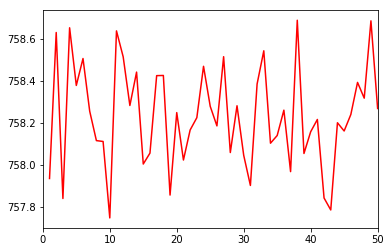

exec_time: 20.549070835113525
DM_option: [  0.        0.        0.       26.75247   0.        0.        0.
   0.      473.24753]
BP_option: [  0.         0.         0.         0.        26.517355   0.
 357.36664   61.30826   54.80774 ]
Max Exp: 758.6901597315217


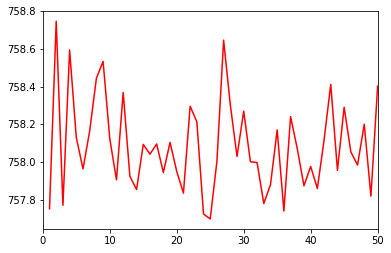

exec_time: 20.595946311950684
DM_option: [  0.         0.         0.         0.        76.748045   5.584475
  69.649145   0.       348.01833 ]
BP_option: [  0.         1.71411    1.096415   0.         0.        32.750565
   0.       260.93493  203.503985]
Max Exp: 758.7464472736225


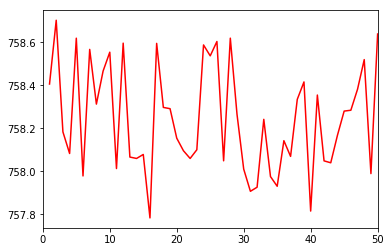

exec_time: 20.491225719451904
DM_option: [  0.         2.07796    0.         0.         0.         0.
  39.001095  27.07375  431.847195]
BP_option: [  0.         0.         0.        22.958825   0.        14.22029
   0.         0.       462.82089 ]
Max Exp: 758.7030054883201


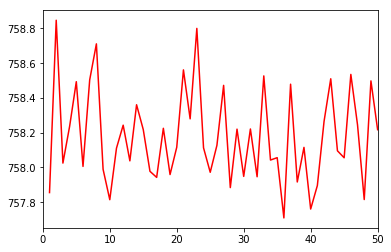

exec_time: 20.556052207946777
DM_option: [  0.         0.         0.       187.228695   0.         0.
   0.        18.013625 294.75768 ]
BP_option: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.37050000e-01
 0.00000000e+00 1.82018900e+01 6.50568000e+00 4.44510775e+02
 3.03446100e+01]
Max Exp: 758.8470729737112


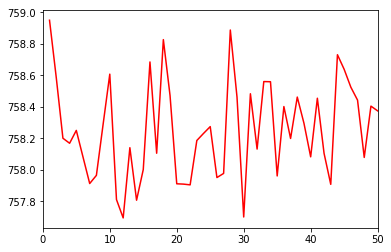

exec_time: 21.996201753616333
DM_option: [  1.53178    0.         0.         5.5769     0.        69.74909
 126.68019   64.915845 231.546195]
BP_option: [  0.         0.         0.         0.         0.         0.
   0.        84.430725 415.569275]
Max Exp: 758.9488062006594
Mean_Time: 21.996201753616333
Mean Fitness: 758.787098333567
---------POP SIZE: 60 ------------


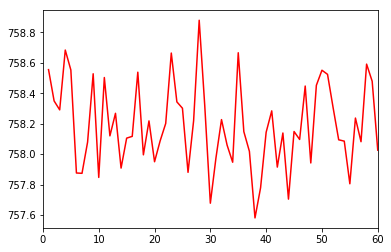

exec_time: 24.62018918991089
DM_option: [  0.        0.        0.        0.        0.       30.15156   0.
 469.84844   0.     ]
BP_option: [  0.        0.        0.        0.       43.20097   0.        0.
   0.      456.79903]
Max Exp: 758.8805464283743


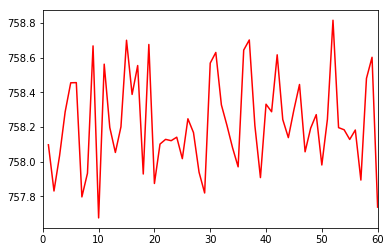

exec_time: 24.598247528076172
DM_option: [  0.        0.       38.68203   0.      186.12315   0.        8.27256
 105.11863 161.80363]
BP_option: [  0.         0.        21.507795   0.         0.         0.
 179.507145 284.826385  14.15868 ]
Max Exp: 758.8149437374607


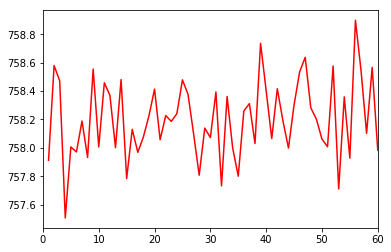

exec_time: 25.132818937301636
DM_option: [  0.         0.         0.        79.27192   24.696155   7.44161
 388.59032    0.         0.      ]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.8981242605427


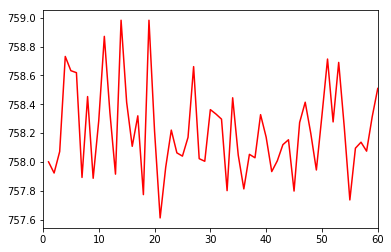

exec_time: 26.46825075149536
DM_option: [  0.         0.89878    0.         0.        43.79418    0.
   0.         0.       455.307035]
BP_option: [  3.811105   0.         0.         0.         0.         0.
   0.       496.188895   0.      ]
Max Exp: 758.9819192022419


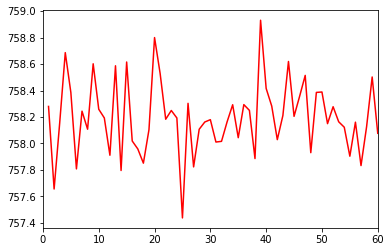

exec_time: 28.103875875473022
DM_option: [  0.         0.        47.203295   0.        33.924085   0.
   0.       188.22071  230.65191 ]
BP_option: [  0.         4.84541    0.        16.273905   0.        60.58902
   3.318645   0.       414.973015]
Max Exp: 758.9311193233019
Mean_Time: 28.103875875473022
Mean Fitness: 758.9013305903843
---------POP SIZE: 70 ------------


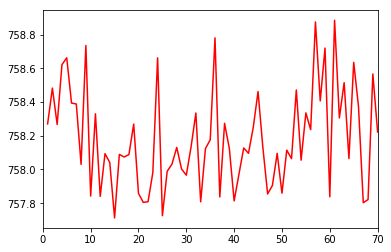

exec_time: 33.701913833618164
DM_option: [  0.         0.         0.         2.21214   45.82883    0.
   5.586445 326.165935 120.20665 ]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.8852840629062


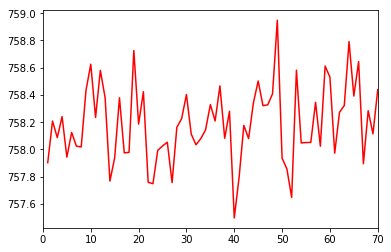

exec_time: 32.99176383018494
DM_option: [  0.         0.         0.        56.73562   68.15482    0.
   2.725465   0.       372.384095]
BP_option: [  0.         0.        22.022055   0.         0.         0.
   0.       105.97325  372.004695]
Max Exp: 758.9485324730798


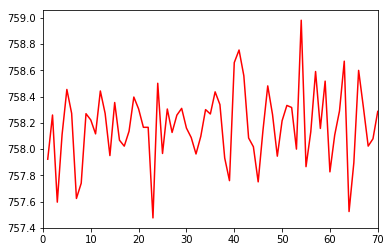

exec_time: 28.622490644454956
DM_option: [  0.         0.        66.044795   0.         0.         0.
   0.         0.       433.955205]
BP_option: [  0.         0.         0.         0.         0.       155.945005
   0.         0.       344.054995]
Max Exp: 758.9819192022419


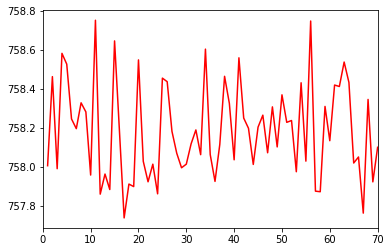

exec_time: 28.838913917541504
DM_option: [  0.         0.       125.60642    0.        11.863745  45.76611
 189.534105  39.18187   88.047755]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.7512294245488


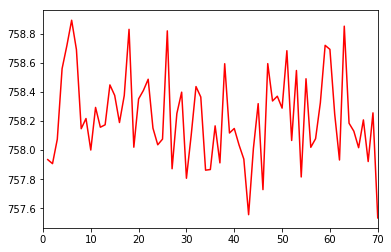

exec_time: 29.205930709838867
DM_option: [  0.        10.068735   0.        41.473065 149.36714   49.30904
 188.419705  61.36231    0.      ]
BP_option: [  0.         0.         6.94562   14.32368    0.         0.
   0.       459.550175  19.18053 ]
Max Exp: 758.8914698747383
Mean_Time: 29.205930709838867
Mean Fitness: 758.891687007503
---------POP SIZE: 80 ------------


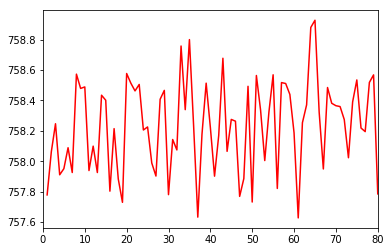

exec_time: 33.049657583236694
DM_option: [  0.         0.       135.64761    0.        33.096835 331.255555
   0.         0.         0.      ]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.9273771823218


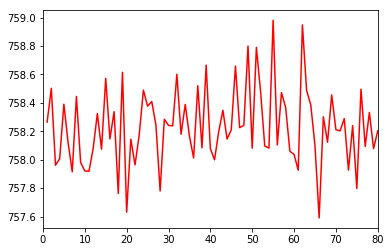

exec_time: 32.68662762641907
DM_option: [  0.         0.        67.224215  51.331525   1.362     21.284275
   0.       104.65237  254.145615]
BP_option: [  0.         0.         0.         0.        16.486225   0.
   0.       447.910725  35.60305 ]
Max Exp: 758.9819192022419


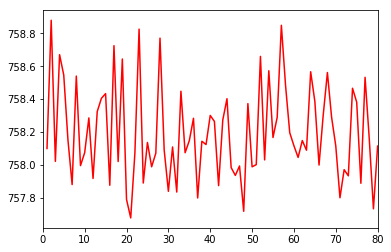

exec_time: 34.59650945663452
DM_option: [  0.        37.99825    0.         0.         0.         0.
   0.       235.19425  226.807505]
BP_option: [  0.        0.        0.        0.        0.       30.78733  31.36987
  85.13336 352.70944]
Max Exp: 758.8793622837967


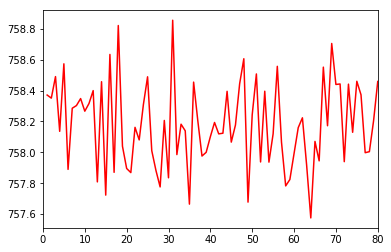

exec_time: 35.027371644973755
DM_option: [  0.         0.         0.         0.        13.259      0.
 108.303015   0.       378.437985]
BP_option: [  0.         0.         3.254055   0.        18.68746    0.
   0.       443.423575  34.63491 ]
Max Exp: 758.8557979534081


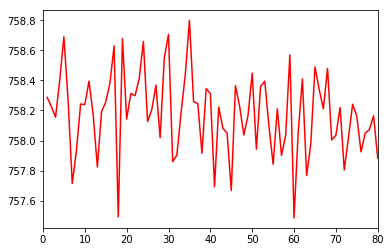

exec_time: 37.715219020843506
DM_option: [  0.        0.        0.        0.       75.84473   0.        0.
   0.      424.15527]
BP_option: [  0.         0.         4.54527    0.       134.3957     0.
   0.       302.955005  58.104025]
Max Exp: 758.8001620827844
Mean_Time: 37.715219020843506
Mean Fitness: 758.8889237409105
---------POP SIZE: 90 ------------


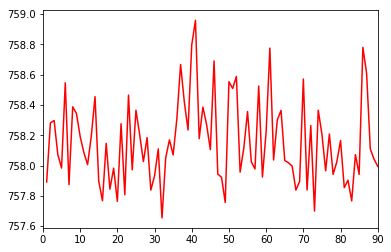

exec_time: 40.139705181121826
DM_option: [  0.         0.        48.099295   0.         0.        65.82921
 386.071495   0.         0.      ]
BP_option: [  0.         0.         0.         0.         0.         0.
   0.        17.137075 482.862925]
Max Exp: 758.958316418005


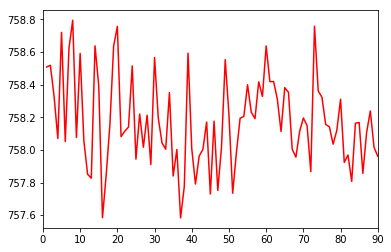

exec_time: 40.638368129730225
DM_option: [  0.         7.445845   0.       134.40456   82.05838   88.850105
   0.         0.       187.24111 ]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.7941656272893


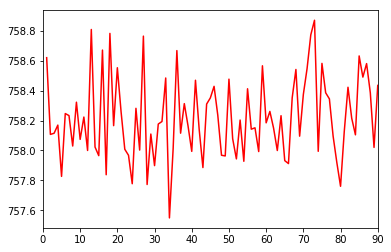

exec_time: 36.72682738304138
DM_option: [  0.         4.961625   0.         0.       155.35828    0.
   0.         0.       339.680095]
BP_option: [  0.         0.         0.         0.        10.512515  15.149965
   0.         0.       474.33752 ]
Max Exp: 758.8704062869053


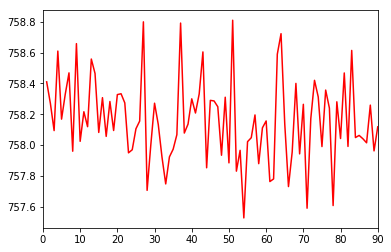

exec_time: 37.452892541885376
DM_option: [  0.         0.         0.         0.        28.23762    0.
 231.142535  93.46703  147.152815]
BP_option: [  0.         0.         0.         0.        41.3335     0.
   0.        29.001695 429.664805]
Max Exp: 758.8092678514765


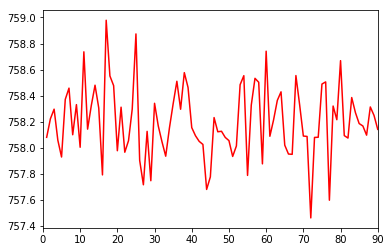

exec_time: 37.06492328643799
DM_option: [  0.         0.         0.        42.452455  14.16687    0.
   0.       193.553635 249.827035]
BP_option: [  0.         0.         9.60726    0.         0.        16.185445
 130.179635 344.02766    0.      ]
Max Exp: 758.9786357526082
Mean_Time: 37.06492328643799
Mean Fitness: 758.8821583872568
---------POP SIZE: 100 ------------


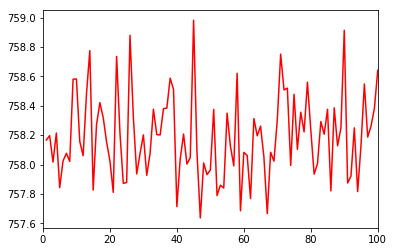

exec_time: 41.04428672790527
DM_option: [  0.         0.         0.         0.         0.        34.450725
   0.         0.       465.549275]
BP_option: [  0.         0.         0.         0.         0.        31.376485
 120.612715  12.156105 335.854695]
Max Exp: 758.9819192022419


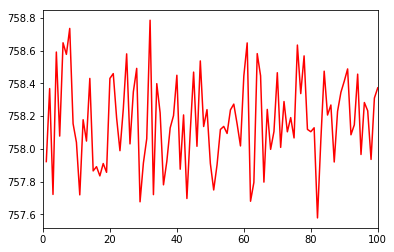

exec_time: 42.42659258842468
DM_option: [  0.        42.30973    0.        19.07409    5.032515   0.
  11.22169   80.32497  342.037005]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.7854214404242


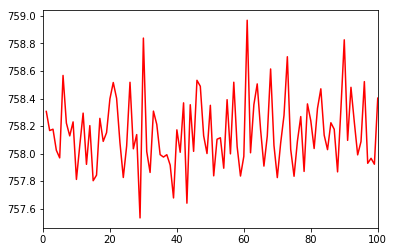

exec_time: 41.743419885635376
DM_option: [  0.       25.11851   0.        0.        0.        0.        0.
  90.44719 384.4343 ]
BP_option: [  0.        0.        0.        0.        0.        0.      104.6865
 198.22761 197.08589]
Max Exp: 758.9682792701107


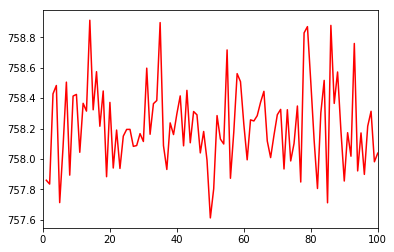

exec_time: 43.961488485336304
DM_option: [  0.         0.       111.99875    0.       115.89415   55.59594
  18.324735   0.       198.186425]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.9131612311521


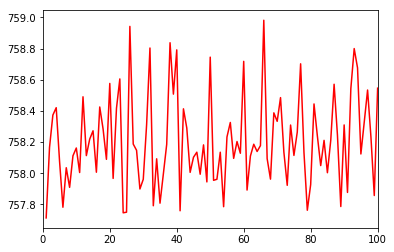

exec_time: 42.961164474487305
DM_option: [  0.         0.         0.         0.         0.        95.07405
  21.538795 136.518025 246.869135]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.9819192022419
Mean_Time: 42.961164474487305
Mean Fitness: 758.9261400692342
---------POP SIZE: 110 ------------


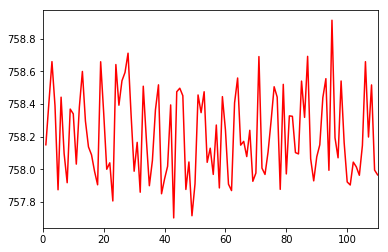

exec_time: 45.35875487327576
DM_option: [  0.         0.         0.         0.         0.         0.
   0.       264.211225 235.788775]
BP_option: [  0.   0.   0.   0.   0.   0. 500.   0.   0.]
Max Exp: 758.9129999943582


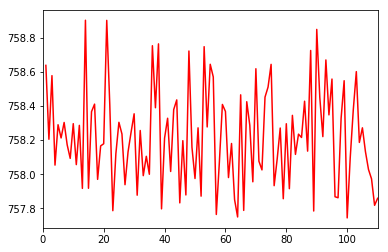

exec_time: 45.0176682472229
DM_option: [  0.         0.        32.251845   0.         6.443445   0.
 454.936385   6.368325   0.      ]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.9010434956868


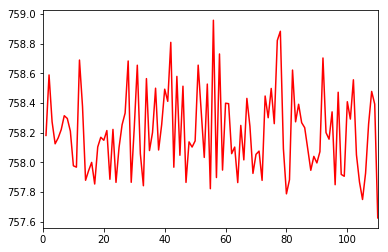

exec_time: 45.614078521728516
DM_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
BP_option: [  0.         0.         0.        18.115855 164.261185  89.40231
   0.         0.       228.22065 ]
Max Exp: 758.9588518821264


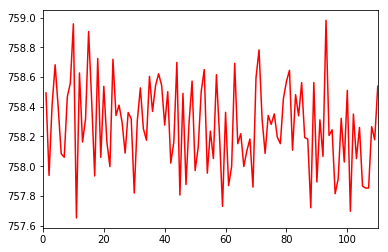

exec_time: 50.029123306274414
DM_option: [  0.        0.        0.      160.23052   0.        0.        0.
   0.      339.76948]
BP_option: [  0.         0.         0.         0.         0.         0.
   7.477245   0.       492.522755]
Max Exp: 758.9819192022419


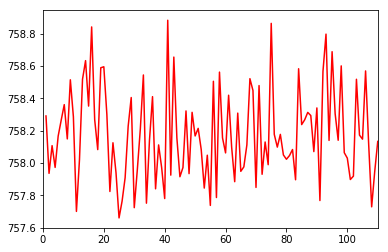

exec_time: 50.071110010147095
DM_option: [  0.         0.         2.289205   0.         0.         0.
   0.       188.23807  309.472725]
BP_option: [  0.        19.40641    0.         0.         0.         0.
   0.       419.0552    61.538385]
Max Exp: 758.8827265458107
Mean_Time: 50.071110010147095
Mean Fitness: 758.9275082240449
---------POP SIZE: 120 ------------


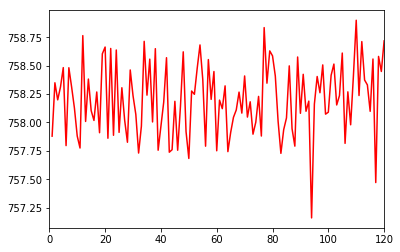

exec_time: 50.98580622673035
DM_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
BP_option: [  0.         0.         0.         0.        26.39832   22.39972
  27.536045  11.82623  411.83969 ]
Max Exp: 758.9006166483397


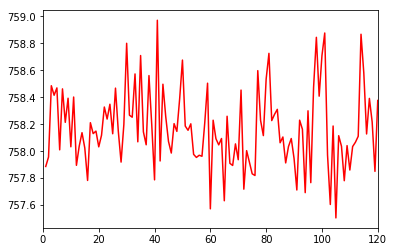

exec_time: 53.30152344703674
DM_option: [  0.         7.532285  79.015845   8.403955   0.         0.
  17.76765   35.11252  352.16775 ]
BP_option: [  0.        0.        3.22417   0.        0.        0.        0.
 496.77583   0.     ]
Max Exp: 758.9703304202553


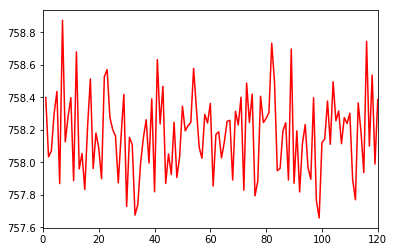

exec_time: 53.788222312927246
DM_option: [  0.         0.         0.         0.         0.         0.
   0.       228.851685 271.148315]
BP_option: [  0.         0.        32.971735   0.         0.         0.
   0.        55.467805 411.56046 ]
Max Exp: 758.8738170050939


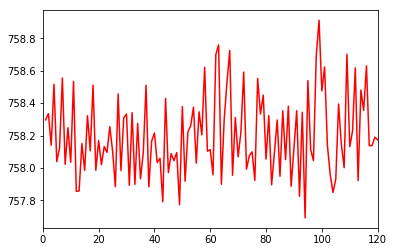

exec_time: 51.44947361946106
DM_option: [  0.         0.        32.52449    0.         0.        57.306425
 248.44119    0.       161.727895]
BP_option: [  0.         0.         0.        18.6519     0.         0.
   0.         6.343135 475.004965]
Max Exp: 758.911969290662


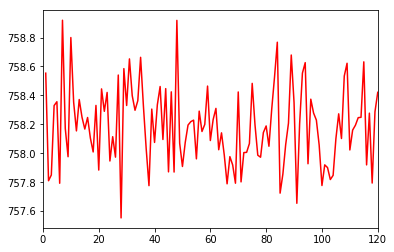

exec_time: 52.216416120529175
DM_option: [  0.         0.446855   0.         0.        17.86984    0.
   0.       312.143535 169.53977 ]
BP_option: [  0.        0.        0.        2.13445   0.        0.       51.72048
   0.      446.14507]
Max Exp: 758.9197500025224
Mean_Time: 52.216416120529175
Mean Fitness: 758.9152966733747
---------POP SIZE: 130 ------------


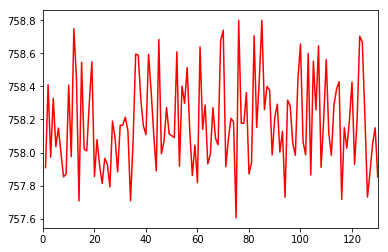

exec_time: 53.926852226257324
DM_option: [  0.        0.        0.      131.18327   0.        0.        0.
   0.      368.81673]
BP_option: [  0.         0.        36.34044    4.24102   11.217555  37.771905
 125.26171  285.16737    0.      ]
Max Exp: 758.8001620827844


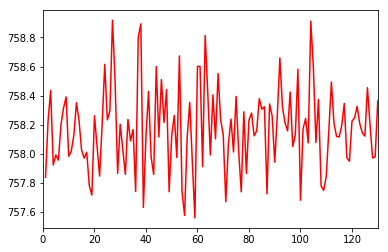

exec_time: 53.625656604766846
DM_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
BP_option: [  0.        0.       28.96259   0.       37.47365   0.       19.80833
 413.75543   0.     ]
Max Exp: 758.9186161470067


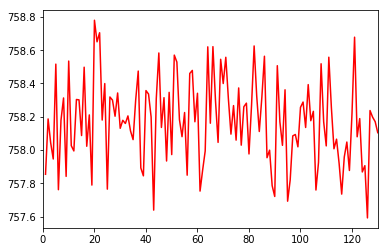

exec_time: 53.1499297618866
DM_option: [  0.         0.        31.3695     0.         0.         0.
   0.         6.62469  462.005805]
BP_option: [  0.        0.        0.        0.       28.75134   0.      471.24866
   0.        0.     ]
Max Exp: 758.7801537638966


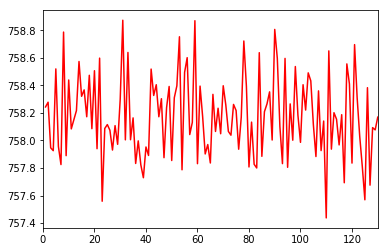

exec_time: 55.53255915641785
DM_option: [  0.         0.         0.        65.907045   0.         0.
  26.99376  259.983895 147.1153  ]
BP_option: [  0.         0.         0.         0.         0.         0.
 104.241995 253.516605 142.2414  ]
Max Exp: 758.8727911484002


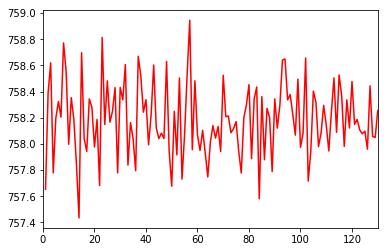

exec_time: 53.23171019554138
DM_option: [  0.         0.         0.        95.8392     0.       178.062115
   0.        54.89631  171.202375]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.9446876073762
Mean_Time: 53.23171019554138
Mean Fitness: 758.8632821498928
---------POP SIZE: 140 ------------


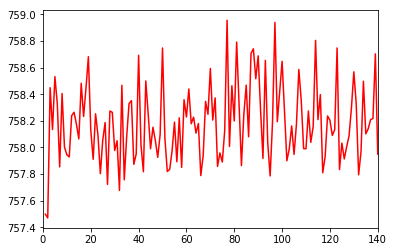

exec_time: 58.19643974304199
DM_option: [  0.        0.        0.        0.      141.30114   0.        0.
 358.69886   0.     ]
BP_option: [  0.         0.         0.        12.88888    0.         0.
   3.22429  241.525105 242.361725]
Max Exp: 758.9556799395931


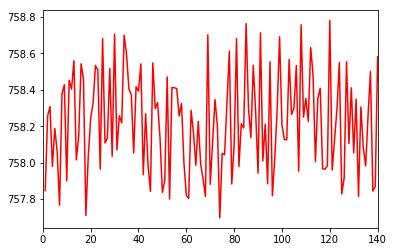

exec_time: 57.423542499542236
DM_option: [  0.         0.         0.         0.         0.        14.73481
  13.11583   77.897745 394.251615]
BP_option: [  0.         0.        22.989325   0.         0.         9.969545
  16.53221    0.       450.508925]
Max Exp: 758.7830260003917


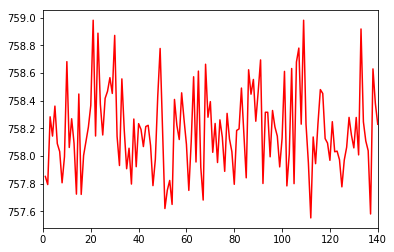

exec_time: 57.75362253189087
DM_option: [  0.         0.         0.        85.372815  56.60264    7.353055
   0.         0.       350.67149 ]
BP_option: [  0.         0.         0.         0.         0.        34.265515
 192.382435   0.       273.35205 ]
Max Exp: 758.9819192022419


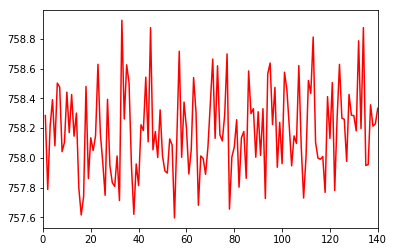

exec_time: 57.69976496696472
DM_option: [  0.        0.        0.      239.49563   0.        0.        0.
   0.      260.50437]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.9245619692804


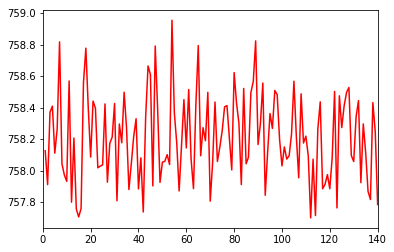

exec_time: 57.98500394821167
DM_option: [  0.        0.        0.       19.44138   0.        0.        0.
 269.15713 211.40149]
BP_option: [  0.         0.        15.300875   0.         0.       165.1057
   0.       319.593425   0.      ]
Max Exp: 758.9547953356873
Mean_Time: 57.98500394821167
Mean Fitness: 758.9199964894389


In [13]:
for i in range(50, 150, 10):
    exec_vector = []
    fitness_vector = []
    print('---------POP SIZE:', i, '------------')
    for _ in range(5):
        exec_time, GLOBAL_BEST = evolution(70, 490, i, 1)
        exec_vector.append(exec_time)
        fitness_vector.append(GLOBAL_BEST)
    print('Mean_Time:',np.mean(exec_time))
    print('Mean Fitness:', np.mean(fitness_vector))

### Calculate Maximun Prob of  Rev more than USD $706 

---------POP SIZE: 50 ------------


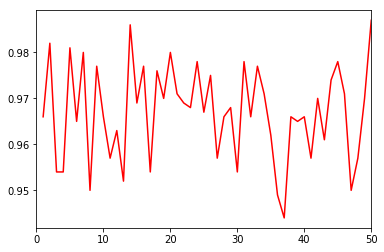

exec_time: 21.561365604400635
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [0.0000000e+00 3.3924578e+02 1.9414000e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.1508455e+01 8.9051625e+01]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


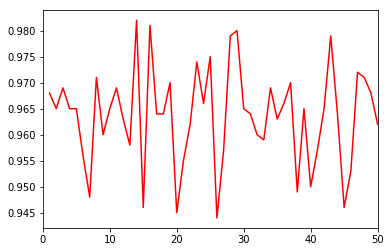

exec_time: 21.53443717956543
DM_option: [  7.455775   6.04978  471.89441    0.         0.         3.332205
   0.         7.49807    3.769765]
BP_option: [ 96.47543   54.45961  261.107785   4.43515    1.7013     0.
  62.2758    19.544925   0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


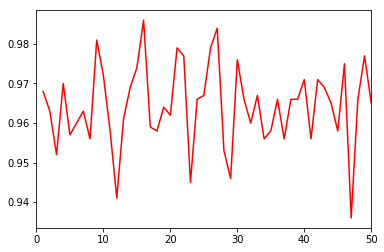

exec_time: 21.557374954223633
DM_option: [  3.86921  225.232735 240.441925   0.        16.829075   0.
  13.627055   0.         0.      ]
BP_option: [  0.       168.368875  92.338895 110.14664    0.         0.
   0.        38.04313   91.10246 ]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


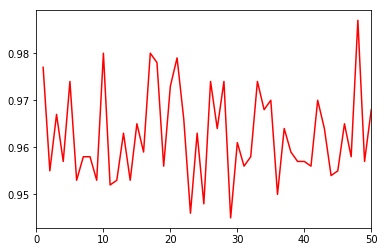

exec_time: 21.53443717956543
DM_option: [  0.      382.26752   0.      117.73248   0.        0.        0.
   0.        0.     ]
BP_option: [107.80454  187.298975   0.         0.         0.        52.897685
   0.         0.       151.9988  ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


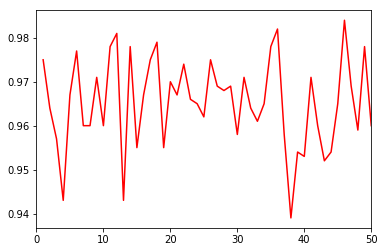

exec_time: 21.32499670982361
DM_option: [6.5056150e+00 4.5033048e+02 8.1510600e+00 2.4011950e+00 1.1630300e+00
 1.6474410e+01 1.4861460e+01 1.1275000e-01 0.0000000e+00]
BP_option: [ 18.168515 312.95753    0.         0.         7.51594  161.358015
   0.         0.         0.      ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014
Mean_Time: 21.32499670982361
Mean Fitness: 0.9852000000000001
---------POP SIZE: 60 ------------


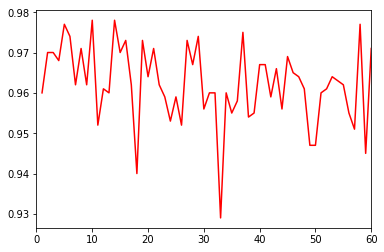

exec_time: 25.143788814544678
DM_option: [  0.      244.12026 239.35021   0.        0.        0.        0.
   0.       16.52953]
BP_option: [  1.707025 330.634625   0.        41.778545   0.        36.595295
  64.032095  25.25242    0.      ]
More than USD $706 Prob: 0.978
1-prob: 0.02200000000000002


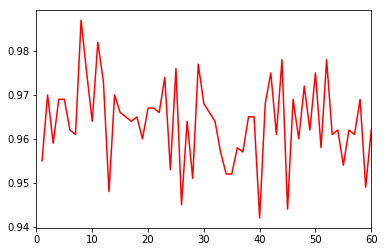

exec_time: 25.349241495132446
DM_option: [  0.         0.       456.137965  43.862035   0.         0.
   0.         0.         0.      ]
BP_option: [ 20.775215   0.       412.291575   2.045775   3.06869    0.
  28.328925   0.        33.48982 ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


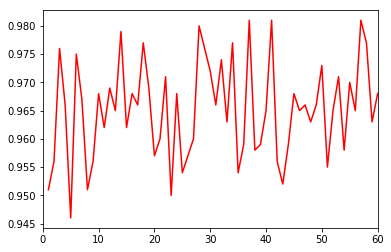

exec_time: 25.187671661376953
DM_option: [  2.153385 484.489455   0.         0.         0.         0.
  13.357165   0.         0.      ]
BP_option: [149.279745 175.13488    0.         0.         0.         0.
 137.13976    0.        38.445615]
More than USD $706 Prob: 0.981
1-prob: 0.019000000000000017


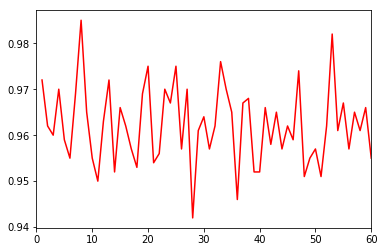

exec_time: 25.169718742370605
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [142.46435  132.884815   0.       161.730695   0.        28.74717
   0.        21.64836   12.52461 ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


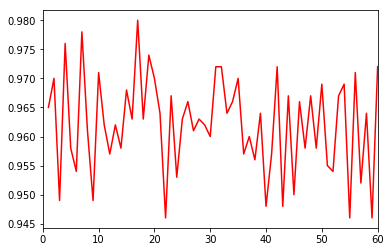

exec_time: 24.917394638061523
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [ 18.647425 125.043955 281.756835   0.         0.         0.
  21.430975  53.12081    0.      ]
More than USD $706 Prob: 0.98
1-prob: 0.020000000000000018
Mean_Time: 24.917394638061523
Mean Fitness: 0.9822
---------POP SIZE: 70 ------------


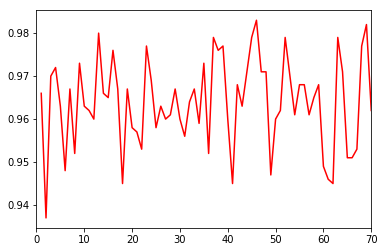

exec_time: 29.556992292404175
DM_option: [  2.93939 475.30432   0.        0.        0.        0.        0.
  21.75629   0.     ]
BP_option: [  0.       226.215545 158.47054    0.         0.       115.313915
   0.         0.         0.      ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


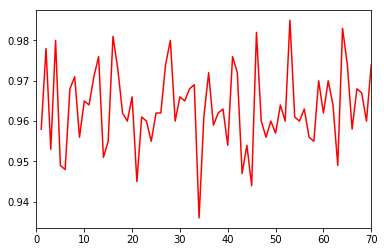

exec_time: 29.264776706695557
DM_option: [  0.       479.350055   0.         0.         0.         0.
  20.649945   0.         0.      ]
BP_option: [  0.       378.84034    0.         0.         0.         0.
   2.46276   63.130535  55.56636 ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


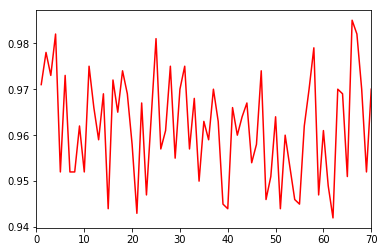

exec_time: 31.67484474182129
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [ 20.10565   79.74312  246.39183    0.         0.         3.38829
   3.150675 147.22043    0.      ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


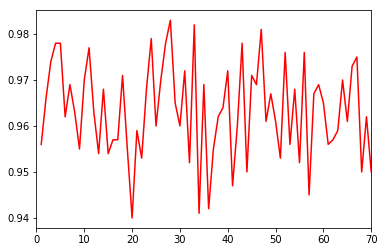

exec_time: 30.88743782043457
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [  0.         0.       291.251485   0.       128.714475   0.
  24.276645   0.        55.757395]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


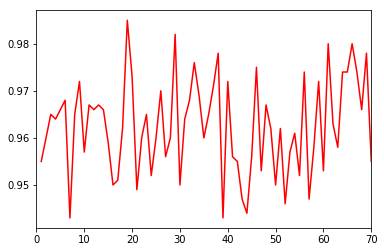

exec_time: 30.681050300598145
DM_option: [  0.       445.9738    43.452165   0.         0.         0.
   0.        10.57403    0.      ]
BP_option: [  0.       341.607885  91.31913    0.         0.         0.
   0.        44.775925  22.297055]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013
Mean_Time: 30.681050300598145
Mean Fitness: 0.9842000000000001
---------POP SIZE: 80 ------------


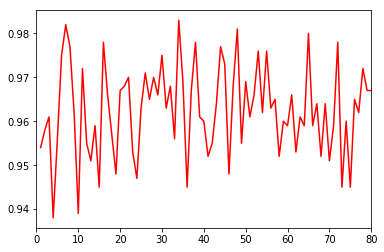

exec_time: 34.101845264434814
DM_option: [  0.       65.98261 434.01739   0.        0.        0.        0.
   0.        0.     ]
BP_option: [  0.        78.07356  319.913665   0.        26.182825   0.
   0.        75.82995    0.      ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


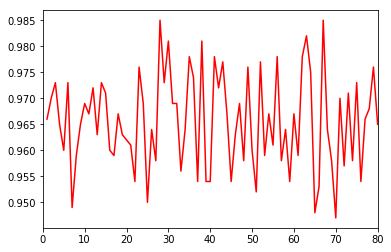

exec_time: 34.57067394256592
DM_option: [  7.96746   55.607535 366.34404   43.663085   0.         3.5222
  22.89568    0.         0.      ]
BP_option: [1.03568420e+02 2.00393735e+02 0.00000000e+00 1.36855000e-01
 0.00000000e+00 0.00000000e+00 1.95900990e+02 0.00000000e+00
 0.00000000e+00]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


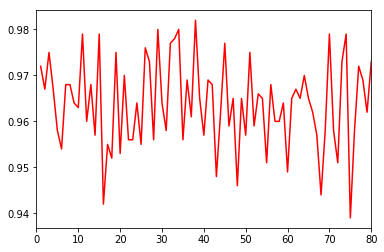

exec_time: 35.24577307701111
DM_option: [  0.        76.88246  397.97393    0.         0.         0.
   0.        22.544535   2.59907 ]
BP_option: [ 15.87422 237.30491  83.49322   0.        0.       97.19788   0.
   0.       66.12977]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


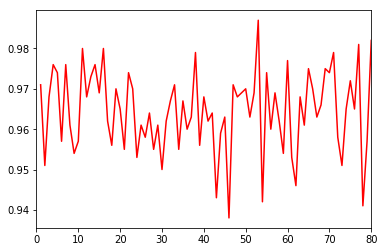

exec_time: 36.499717473983765
DM_option: [  0.        0.      488.53965   0.        0.       11.46035   0.
   0.        0.     ]
BP_option: [  0.       308.234855   0.         1.536015  42.10273    0.
   0.         0.       148.1264  ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


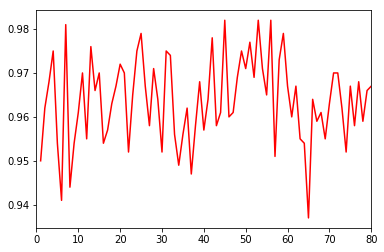

exec_time: 35.347498416900635
DM_option: [  0.       327.267565 172.732435   0.         0.         0.
   0.         0.         0.      ]
BP_option: [255.492435  41.40325    0.         0.         0.         0.
   0.       203.104315   0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016
Mean_Time: 35.347498416900635
Mean Fitness: 0.9838000000000001
---------POP SIZE: 90 ------------


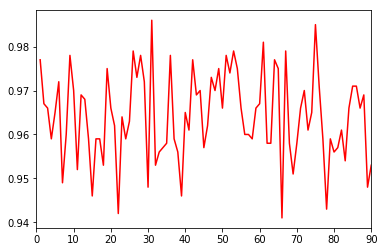

exec_time: 38.81823682785034
DM_option: [  0.       427.160315   0.         0.        72.839685   0.
   0.         0.         0.      ]
BP_option: [  0.      378.33692   0.        0.        0.      121.66308   0.
   0.        0.     ]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


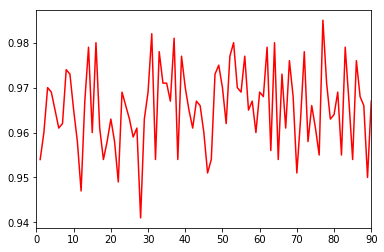

exec_time: 37.52968215942383
DM_option: [  0.         0.       469.866975   0.522975   0.         0.
  28.53248    0.         1.07757 ]
BP_option: [  0.       297.20567  122.975175   0.         0.         0.
   0.        79.81915    0.      ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


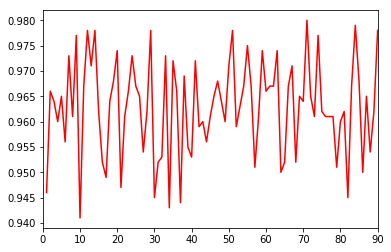

exec_time: 37.433932065963745
DM_option: [  0.       161.801615 338.198385   0.         0.         0.
   0.         0.         0.      ]
BP_option: [  0.      342.41257   0.        0.        0.      157.58743   0.
   0.        0.     ]
More than USD $706 Prob: 0.98
1-prob: 0.020000000000000018


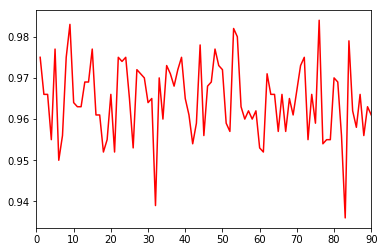

exec_time: 37.461862087249756
DM_option: [  0.       153.29315   82.045145 222.00712    0.        21.87665
   0.        20.77793    0.      ]
BP_option: [  5.109775 316.143715   0.         0.         0.         0.
  77.111165   0.       101.635345]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


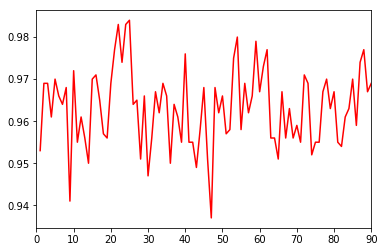

exec_time: 38.58984923362732
DM_option: [  0.        92.270975  89.73858  317.990445   0.         0.
   0.         0.         0.      ]
BP_option: [ 61.601535 293.831605   0.         0.         0.         0.
   0.        20.37842  124.18844 ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014
Mean_Time: 38.58984923362732
Mean Fitness: 0.9838000000000001
---------POP SIZE: 100 ------------


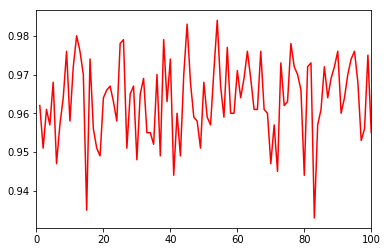

exec_time: 41.491093158721924
DM_option: [  0.       394.678635  91.091155   0.         0.         0.
   0.        14.23021    0.      ]
BP_option: [  0.        33.34858  300.583075   0.         0.         0.
 166.06835    0.         0.      ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


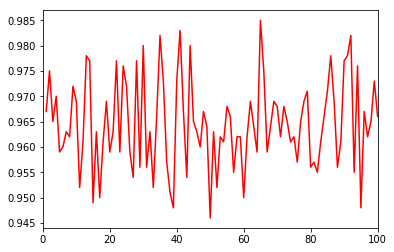

exec_time: 41.58484411239624
DM_option: [  0.         0.       494.537035   0.         0.         0.
   5.462965   0.         0.      ]
BP_option: [225.73642   45.056645  25.149415   0.         0.         0.
   8.312155   5.64645  190.098915]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


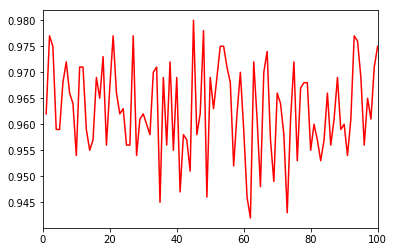

exec_time: 41.70151615142822
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [170.35433  160.715385   0.         0.        16.254045   0.
   0.       152.67624    0.      ]
More than USD $706 Prob: 0.98
1-prob: 0.020000000000000018


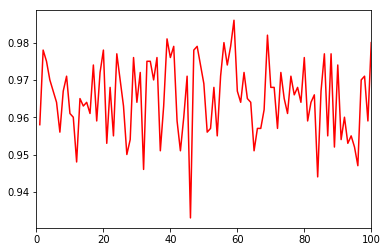

exec_time: 45.519325971603394
DM_option: [  1.76514    0.       476.16791    0.         0.        22.066945
   0.         0.         0.      ]
BP_option: [ 43.64925 288.37412   0.        0.       42.3503    0.        0.
   0.      125.62633]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


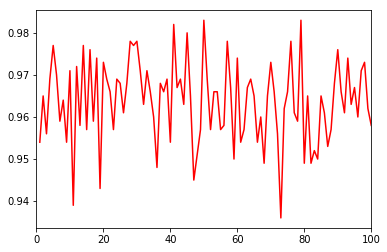

exec_time: 43.968082427978516
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [ 55.392785 184.17631    0.       167.06638   14.671395  66.09827
   0.         0.        12.59486 ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015
Mean_Time: 43.968082427978516
Mean Fitness: 0.9835999999999998
---------POP SIZE: 110 ------------


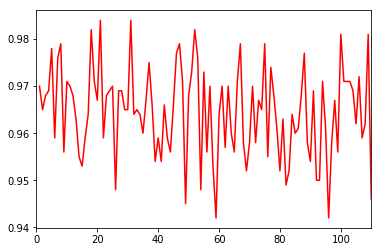

exec_time: 46.08980131149292
DM_option: [  0.        0.      483.70794   0.        0.        0.       16.29206
   0.        0.     ]
BP_option: [ 23.312875 187.299785   0.        95.771585   0.       179.76273
   0.         0.        13.85303 ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


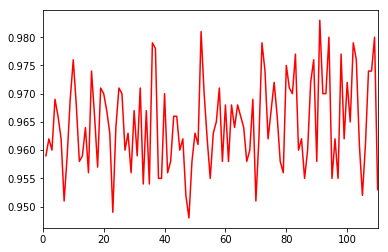

exec_time: 48.84244346618652
DM_option: [  0.        12.077305 312.63158    2.417235 172.87388    0.
   0.         0.         0.      ]
BP_option: [  1.76726   52.31086  315.379255   0.         8.244095   0.
  23.178165   5.07236   94.048005]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


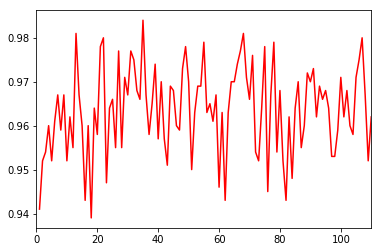

exec_time: 46.35354685783386
DM_option: [  0.       368.087615   0.        56.056385  75.856      0.
   0.         0.         0.      ]
BP_option: [  0.       237.996715 157.675365   0.        13.491215   0.
  50.118335  31.89406    8.82431 ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


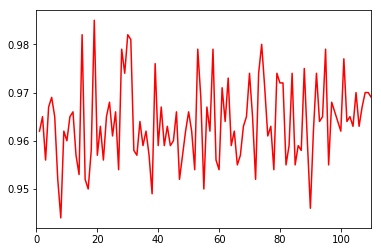

exec_time: 45.70183801651001
DM_option: [  6.05352 429.39303  46.01733  18.53612   0.        0.        0.
   0.        0.     ]
BP_option: [112.56803  166.606195  21.25235    0.        13.554825  36.95462
   0.        48.00191  101.062065]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


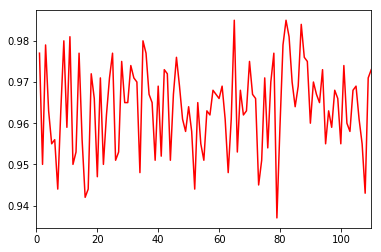

exec_time: 45.3427996635437
DM_option: [0.0000000e+00 4.9678694e+02 0.0000000e+00 1.5374350e+00 0.0000000e+00
 6.2750000e-02 1.6128750e+00 0.0000000e+00 0.0000000e+00]
BP_option: [  0.       200.167225 165.463315  26.150685   0.         0.
   0.         0.       108.218775]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013
Mean_Time: 45.3427996635437
Mean Fitness: 0.9842000000000001
---------POP SIZE: 120 ------------


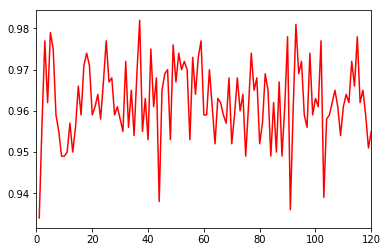

exec_time: 50.66257572174072
DM_option: [  0.        0.      473.64737   0.        0.       26.35263   0.
   0.        0.     ]
BP_option: [ 13.16346    0.       427.564695   2.786485   0.        30.651315
   0.         9.92497   15.90908 ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


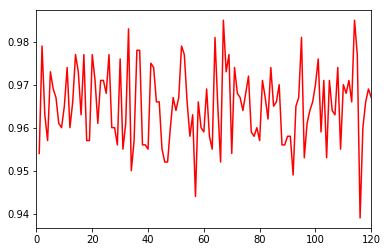

exec_time: 50.57680702209473
DM_option: [  0.        0.      370.43993 129.56007   0.        0.        0.
   0.        0.     ]
BP_option: [ 72.85467  145.40505  187.73234    0.         0.         0.
   0.        12.54738   81.460555]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


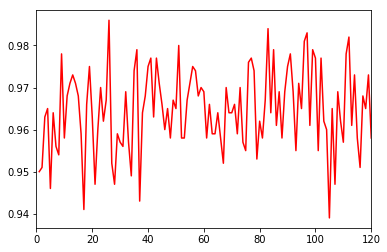

exec_time: 50.41025161743164
DM_option: [1.8352500e-01 3.4506383e+02 1.6718060e+01 6.0948740e+01 5.6612300e+01
 0.0000000e+00 0.0000000e+00 2.0473545e+01 0.0000000e+00]
BP_option: [  8.522045 241.203085  37.44193   45.072615  36.04968   28.24226
   0.         3.802785  99.6656  ]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


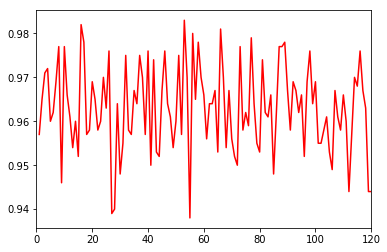

exec_time: 50.0262770652771
DM_option: [  0.       0.     390.3374   0.       0.     109.6626   0.       0.
   0.    ]
BP_option: [  0.         0.       347.8016    13.052305  18.37897    0.
   0.       116.21631    4.55082 ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


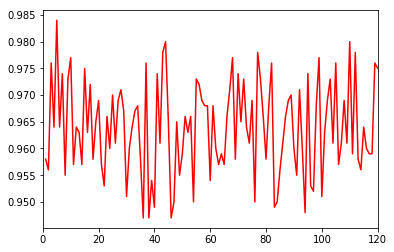

exec_time: 49.846759557724
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [ 54.038255 323.12088    0.         0.         0.         0.
   0.       122.840865   0.      ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014
Mean_Time: 49.846759557724
Mean Fitness: 0.984
---------POP SIZE: 130 ------------


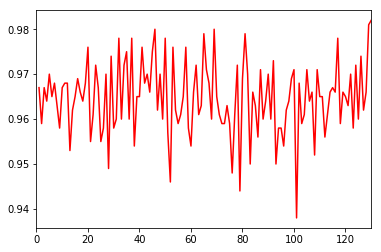

exec_time: 54.305838108062744
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [  0.       315.970885   0.         0.         0.         0.
 184.029115   0.         0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


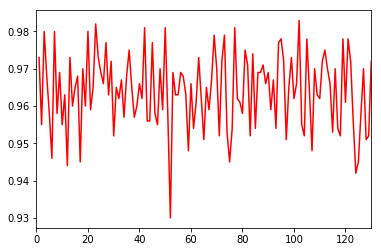

exec_time: 54.07844614982605
DM_option: [  0.       456.63799    0.        28.95417    0.        14.407835
   0.         0.         0.      ]
BP_option: [  0.       308.541075   0.         0.         5.429235  96.09917
   0.        14.73345   75.197065]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


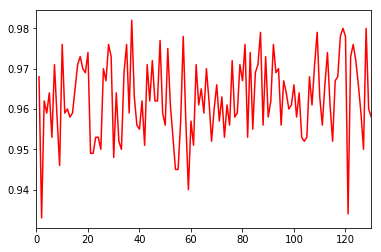

exec_time: 54.23403072357178
DM_option: [  1.846335 455.407815   7.62208    0.        23.974525   0.
   0.        11.14924    0.      ]
BP_option: [  0.       101.480845 253.743885   0.         0.       110.894685
   0.        33.88058    0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


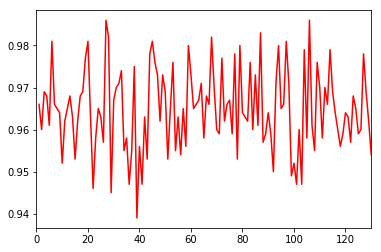

exec_time: 54.09739661216736
DM_option: [  0.         2.30969  433.318795  29.551255   0.        11.531355
   1.075535  17.96209    4.251285]
BP_option: [  0.         0.       395.99052    0.         0.        54.970095
   1.863055   0.        47.17633 ]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


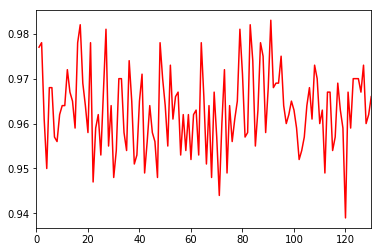

exec_time: 54.530240297317505
DM_option: [  0.       282.20261   58.228235 159.569155   0.         0.
   0.         0.         0.      ]
BP_option: [  0.       317.0676     0.         0.        18.096035 145.3349
   0.        11.078725   8.42274 ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015
Mean_Time: 54.530240297317505
Mean Fitness: 0.9831999999999999
---------POP SIZE: 140 ------------


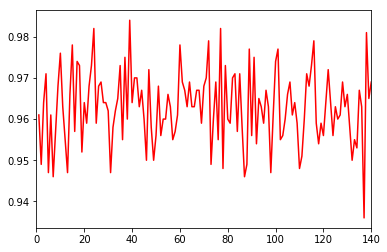

exec_time: 58.1415855884552
DM_option: [  0.         0.       458.017075   0.        32.00242    3.50478
   0.         3.665455   2.810275]
BP_option: [ 78.966875 212.76493    3.890835   0.         0.       122.589365
  32.81748    0.        48.970515]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


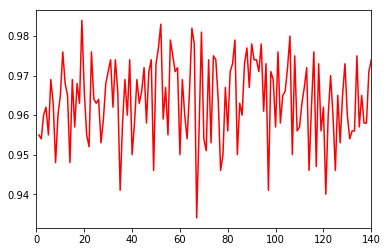

exec_time: 58.55647325515747
DM_option: [  0.        40.77893  416.63273    5.537895   0.        37.050445
   0.         0.         0.      ]
BP_option: [  0.       282.036345  21.39633    0.         0.         0.
 151.071715  45.49561    0.      ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


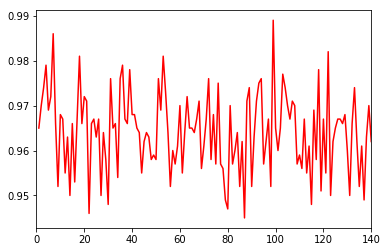

exec_time: 59.08306694030762
DM_option: [  0.       282.660815 125.88174   91.457445   0.         0.
   0.         0.         0.      ]
BP_option: [  3.176905 207.29311  108.199385  60.041985   0.        89.47198
   0.        31.816635   0.      ]
More than USD $706 Prob: 0.989
1-prob: 0.01100000000000001


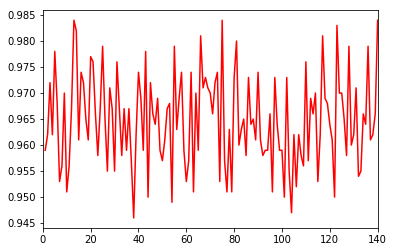

exec_time: 59.76125764846802
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [  0.       307.491705   9.819985   0.         0.         0.
   0.         0.       182.68831 ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


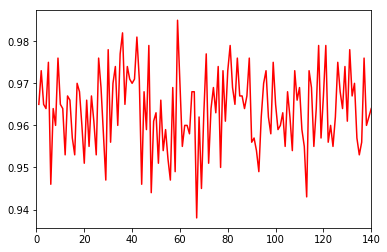

exec_time: 58.174498319625854
DM_option: [  0.       272.9571   173.67733   27.897415   0.         0.
   0.        25.46815    0.      ]
BP_option: [  8.429915 302.41814    0.        13.878025   0.       156.533355
   6.838405   0.        11.902165]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013
Mean_Time: 58.174498319625854
Mean Fitness: 0.9852000000000001


In [14]:
for i in range(50, 150, 10):
    exec_vector = []
    fitness_vector = []
    print('---------POP SIZE:', i, '------------')
    for _ in range(5):
        exec_time, GLOBAL_BEST = evolution(70, 490, i, 0)
        exec_vector.append(exec_time)
        fitness_vector.append(GLOBAL_BEST)
    print('Mean_Time:',np.mean(exec_time))
    print('Mean Fitness:', np.mean(fitness_vector))

In [8]:
a = np.array([[1,2,3], [4,5,6]])
print(a.shape)
b = np.sum((a >= 2), axis = 1)
print(b)

(2, 3)
[2 3]


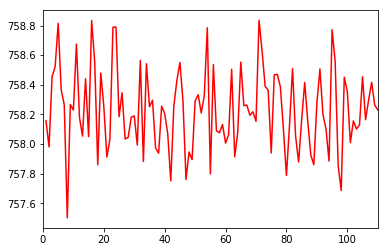

exec_time: 45.90827441215515
DM_option: [  0.        0.        0.        0.        0.        0.        0.
 193.42317 306.57683]
BP_option: [  0.         0.         0.        15.129665   0.        68.966185
   0.       415.231755   0.67239 ]
Max Exp: 758.8356259494163


(45.90827441215515, 758.8356259494163)

In [19]:
evolution(70, 490, 110, 1)

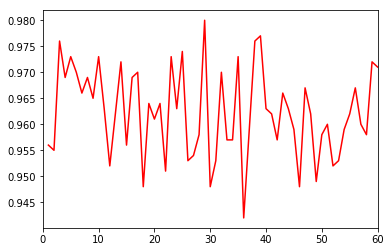

exec_time: 31.511709928512573
DM_option: [  0.       172.591695 327.408305   0.         0.         0.
   0.         0.         0.      ]
BP_option: [  0.       213.818     93.46756    0.         0.       141.342915
   0.         0.        51.371525]
More than USD $706 Prob: 0.98
1-prob: 0.020000000000000018


(31.511709928512573, 0.98)

In [17]:
evolution(70, 490, 60, 0)